In [9]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import _pickle as pickle
import gym
import time
import matplotlib.pyplot as plt

# hyperparameters
hidden_layer_neurons = 200
batch_size = 1 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = True # resume from previous checkpoint?
render = True

# model initialization
game_dimensions = 80 * 80 # input dimensionality: 80x80 grid

In [2]:
!python -m atari_py.import_roms .

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Je

copying name_this_game.bin from ROMS/Name This Game (Guardians of Treasure) (1983) (U.S. Games Corporation - JWDA, Roger Booth, Sylvia Day, Ron Dubren, Todd Marshall, Robin McDaniel, Wes Trager, Henry Will IV) (VC1007) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/name_this_game.bin
copying pacman.bin from ROMS/Pac-Man (1982) (Atari, Tod Frye) (CX2646) (PAL).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/pacman.bin
copying phoenix.bin from ROMS/Phoenix (1983) (Atari - GCC, Mike Feinstein, John Mracek) (CX2673) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/phoenix.bin
copying video_pinball.bin from ROMS/Pinball (AKA Video Pinball) (Zellers).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/video_pinball.bin
copying pitfall.bin from ROMS/Pitfall! - Pitfall Harry's Jungle Adventure (Jungle Runner) (1982) (Activision, David Crane) (AX-01

In [3]:
#TODO: With sqroot, paddle explores more of the board. Why is that?

if resume:
    model = pickle.load(open('save.p', 'rb')) #This allows you to resume training
else:
    model = {}
    model['W1'] = np.random.randn(hidden_layer_neurons, game_dimensions) / np.sqrt(game_dimensions) # "Xavier" initialization. Idea is to set the initial and output variance to be the same so vanishing/exploding gradient doesn't happen
    #Weights live in the connections. Which is why the weights are 200 by 6400 because that is the total number of connections
    model['W2'] = np.random.randn(hidden_layer_neurons) / np.sqrt(hidden_layer_neurons)
    #Stores 200 weights

In [4]:
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def relu(x):
    if x < 0:
        return 0
    return x

def tanh(x):
    return np.tanh(x)

def softmax(x): 
    pass

#TODO: I wonder if we can play around with the downsampling. If you get an error, you need to adjust the game dimensions
#Just see the other number (if you do ::3 then it will be 2916) and take the square root. Then, use replace that
#number with the numbers in the game_dimensions variable

def prepro(input_frame):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    input_frame = input_frame[34:194] # crop
    input_frame = input_frame[::2,::2,0] # downsample by factor of 2 (halves the resolution of the image)
    #This takes every other pixel in the image
    input_frame[input_frame == 144] = 0 # erase background (background type 1)
    input_frame[input_frame == 109] = 0 # erase background (background type 2)
    input_frame[input_frame != 0] = 1 # everything else (paddles, ball) just set to 1
    return input_frame.astype(np.float).ravel()

#TODO: Play around with gamma values

def discount_rewards(rewards):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(rewards)
    running_add = 0
    # print(rewards)  r is a 2d array with the given rewards
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_r[t] = running_add
    return discounted_r

# TODO: look into adding bias
def policy_forward(change_in_frame):
    hidden_layer_values = np.dot(model['W1'], change_in_frame)
    hidden_layer_values[hidden_layer_values<0] = 0 # ReLU nonlinearity
    log_probability = np.dot(model['W2'], hidden_layer_values)
    up_prob = sigmoid(log_probability)
    return up_prob, hidden_layer_values # return probability of taking action 2, and hidden state

In [5]:
# TODO: understand and rename (if needed) dh
# dC_dw1: derivative of the cost / derivative of the weights 1 --> partial derivative
# dC_dw2: derivative of the cost / derivative of the weights 2 --> partial derivative
#comb_ep_hidden_layer_values.T and dh.T are the transposed matrices of comb_ep_hidden_layer_values and dh, respectively
def policy_backward(comb_ep_hidden_layer_values, comb_ep_gradient_log_ps):
    """ backward pass. (comb_ep_hidden_layer_values is array of intermediate hidden states) """
    dC_dw2 = np.dot(comb_ep_hidden_layer_values.T, comb_ep_gradient_log_ps).ravel()
    dh = np.outer(comb_ep_gradient_log_ps, model['W2'])
    
    #Outer Product is kind of simple. If we have [1,2,3] and [[2],[3],[6]], the outer product would be [[2,4,6], [3, 6, 9], [6,12,18]]
    
    dh[comb_ep_hidden_layer_values <= 0] = 0 # backpro prelu
    dC_dw1 = np.dot(dh.T, comb_ep_observations) #Why is comb_ep_observations not a parameter
    return {'W1':dC_dw1, 'W2':dC_dw2}

In [10]:
env = gym.make("Pong-v0")
observation = env.reset() # gets very first image of the game
prev_frame = None # used in computing the difference frame 
ep_observations,ep_hidden_layer_values,ep_gradient_log_ps,ep_rewards = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
all_rewards, all_running_rewards = [], []

for _ in range(6000):
    if render: 
        env.render()
        #time.sleep(0.1)

        # preprocess the observation, set input to network to be difference image
        curr_frame = prepro(observation)
        change_in_frame = curr_frame - prev_frame if prev_frame is not None else np.zeros(game_dimensions)
        prev_frame = curr_frame

        # forward the policy network and sample an action from the returned probability
        up_prob, hidden_layer_values = policy_forward(change_in_frame)
        action = 2 if np.random.uniform() < up_prob else 3 # roll the dice! Generates random probability. This is used for exploring
        
        #2 means up and 3 means down
        
        # record various intermediates (needed later for backprop)
        ep_observations.append(change_in_frame) # observation
        ep_hidden_layer_values.append(hidden_layer_values) # hidden state
        y = 1 if action == 2 else 0 # a "fake label". Our paddle only take the values of 2 and 3 so we need this.
        ep_gradient_log_ps.append(y - up_prob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
        
        #Stores error which is error of the cost. Has something to do with the KL divergence I think at least.
        #This is our loss function
        
        # step the environment and get new measurements
        observation, reward, done, info = env.step(action) #This is where we tell our paddle to move up or down
        reward_sum += reward

        ep_rewards.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: # an episode finished
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            comb_ep_observations = np.vstack(ep_observations) #ep_observations is an array of ep_observations while comb_ep_observations is a 2D array
            comb_ep_hidden_layer_values = np.vstack(ep_hidden_layer_values)
            comb_ep_gradient_log_ps = np.vstack(ep_gradient_log_ps)
            comb_ep_rewards = np.vstack(ep_rewards)
            ep_observations,ep_hidden_layer_values,ep_gradient_log_ps,ep_rewards = [],[],[],[] # reset array memory
            
            #compute the discounted reward backwards through time
            discounted_comb_ep_rewards = discount_rewards(comb_ep_rewards) # comb_ep_rewards is an array of the rewards
            # standardize the rewards to be unit normal (helps control the gradient estimator variance)
            discounted_comb_ep_rewards -= np.mean(discounted_comb_ep_rewards) # calculates mean and subtracts from each value
            discounted_comb_ep_rewards /= np.std(discounted_comb_ep_rewards)
    
            #This is a math trick that normalizes the data to have a mean of 0 and a standard deviation of 1, thus creating a bell curve (I think?)
            #This way the numbers that the neural network has to work with may be easier to handle because they would be smaller and near 0
            #This also doesn't change the policy gradient because of the constant scaling
            #This also centers the data which means that it should theoretically encourage half of the actions while discouraging the second half due to the centering
            
            comb_ep_gradient_log_ps *= discounted_comb_ep_rewards # modulate the gradient with advantage (PG magic happens right here.)
            grad = policy_backward(comb_ep_hidden_layer_values, comb_ep_gradient_log_ps)
            for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch. Why?

            # perform rmsprop parameter update every batch_size episodes
            if episode_number % batch_size == 0:
                for k,v in model.items():
                    g = grad_buffer[k] # gradient
                    rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                    model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                    grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

            # boring book-keeping
            
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01 #What is this
            all_rewards.append(reward_sum)
            all_running_rewards.append(running_reward)
            print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
            if episode_number % 1 == 0: pickle.dump(model, open('save.p', 'wb'))
            reward_sum = 0
            observation = env.reset() # reset env
            prev_frame = None

        if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
            print('ep %d: game finished, reward: %f' % (episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))


# TODO: 
# 1. understand dh and backpropogation functions in policy_backward
# 2. understand what the variable "ep_gradient_log_ps" holds & rename if necessary (line 77)
# and change comb_ep_gradient_log_ps accordingly
# 3. understand grad_buffer 
# 4. understand RMSprop calculations and rename variables if necessary 

ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -21.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, rewar

ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.970890
ep 10: game finished, reward: -1.000000
ep 10: game finished, reward: -1.000000
ep 10: game finished, reward: -1.000000
ep 10: game finished, r

ep 17: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.943832
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
resetting env. episode reward total was -21

KeyboardInterrupt: 

In [11]:
print(all_rewards)

[-21.0, -21.0, -21.0, -21.0, -21.0, -20.0, -20.0, -20.0, -21.0, -21.0, -21.0, -21.0, -21.0, -20.0, -21.0, -20.0, -20.0, -21.0, -21.0, -21.0, -21.0, -20.0, -21.0]


In [12]:
print(all_running_rewards)

[-21.0, -21.0, -21.0, -21.0, -21.0, -20.99, -20.980099999999997, -20.970298999999997, -20.970596009999998, -20.9708900499, -20.971181149401, -20.971469337906992, -20.971754644527923, -20.962037098082643, -20.962416727101818, -20.952792559830797, -20.943264634232488, -20.943831987890164, -20.944393668011262, -20.94494973133115, -20.94550023401784, -20.93604523167766, -20.936684779360885]


In [13]:
episodes = list(range(len(all_rewards)))

In [14]:
print(episodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [24]:
with open("Control.txt", "wb") as fp:   #Pickling
    pickle.dump(all_running_rewards, fp)

with open("Control.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [25]:
print(b)

[-21.0, -21.0, -21.0, -21.0, -21.0, -20.99, -20.980099999999997, -20.970298999999997, -20.970596009999998, -20.9708900499, -20.971181149401, -20.971469337906992, -20.971754644527923, -20.962037098082643, -20.962416727101818, -20.952792559830797, -20.943264634232488, -20.943831987890164, -20.944393668011262, -20.94494973133115, -20.94550023401784, -20.93604523167766, -20.936684779360885]


In [22]:
def create_graph(reward_list, titles):
    fig = plt.figure()
    episodes = list(range(len(reward_list)))
    plt.plot(episodes, reward_list)
    plt.title(titles[0])
    plt.xlabel("Episodes")
    plt.ylabel(titles[1])
    plt.savefig(titles[2] + ".png")

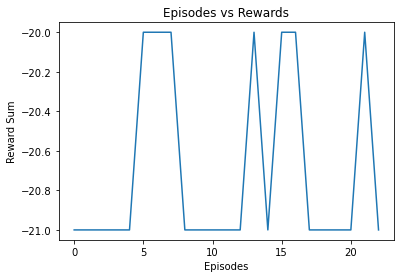

In [20]:
create_graph(all_rewards, ["Episodes vs Rewards", "Reward Sum", "ControlRewardSum"])

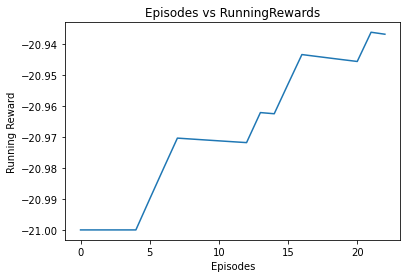

In [23]:
create_graph(all_running_rewards, ["Episodes vs RunningRewards", "Running Reward", "ControlRunningReward"])

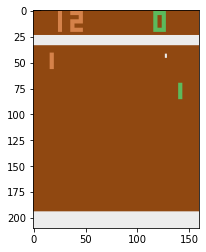

In [8]:
fig = plt.figure()
plt.imshow(observation)
plt.savefig("OriginalImage.png")

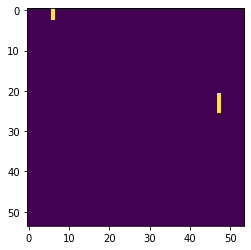

In [37]:
'''fig1 = plt.figure()
observation = observation[34:194]
observation = observation[::3,::3,0] 
observation[observation == 144] = 0
observation[observation == 109] = 0
observation[observation != 0] = 1
plt.imshow(observation)
plt.savefig("NewImage.png")'''